# TP1: CNN denoising

The objective of this lesson is to explore some basic aspects of convolutional neuronal networks (CNN) applied to denoising.
We will show how to define and train a network in pytorch. Then study some simple network architectures and explore their limits.

We will cover the following topics:
* Define a CNN model and load pre-trained weights
* Apply CNN to an images
* Training a CNN
    * Data preparation
    * Network model 
    * Loss function
    * Optimizer
* Residual learning
* Choice of loss
* Weight initialization


**Questions:**
1. robustness of a pretrained CNN to changes of $\sigma$, shifts, and affine contrast changes 
2. train a DCT denoiser, compare with the original DCT denoising
3. train a shalloNN similar to DnCNN and compare with DCT
4. **INCOMPLETE....**


#### Instructions
To solve this TP, answer the question below and send a short report by mail to [facciolo@cmla.ens-cachan.fr](mailto:facciolo@cmla.ens-cachan.fr) with subject "Report TPCNN1 of SURNAME, Name", by tomorrow (9-2-2018).  You will receive an acknowledgement of receipt.

In [ ]:
# This notebook can also run on colab (https://colab.research.google.com/)
# The following lines install the necessary packages in the colab environment
try: 
    from google.colab import files
    !pip install torch==0.4.0
    !pip install torchvision 
    !pip install Pillow==4.0.0
    !pip install scikit-image
    !pip install hdf5storage
    
    !pip install git+https://github.com/szagoruyko/pytorchviz
    !apt-get install graphviz
    
    !rm -fr MVA2018-denoising
    !git clone  https://github.com/gfacciol/MVA2018-denoising.git
    !cp -r MVA2018-denoising/* .

except ImportError:
    pass

In [12]:
## Setup code for the notebook
##
# These are all the includes used through the notebook
import numpy as np     
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io # read and write images
import vistools        # image visualization toolbox

#%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-----------------------------

# Define a denoising CNN


      K. Zhang, W. Zuo, Y. Chen, D. Meng, and L. Zhang, “Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising,” IEEE Trans. Image Process., vol. 26, no. 7, pp. 3142–3155, Jul. 2017.

<img width=700 src="https://raw.githubusercontent.com/gfacciol/MVA2018-denoising/master/models/DnCNN.png"/>


The code below declares the **DnCNN** network. The same definition is also available in the `models` module. 
An instance of the network for grayscale images is created with `model = DnCNN(1,1)` where the parameters `1` indicate the number of input and output channels.
The model is made of atomic blocks such as `nn.Conv2d`, whch represents a convolutional layer. Note how the layers are declared in the `__init__` method of each model and then called in `forward`. 

A newly created network is initialized with random weights. 
Next we'll see how to load pretrained weiths.  

In [ ]:
from models import DnCNN

import torch
import torch.nn as nn



##
class CONV_BN_RELU(nn.Module):
    '''
    model for a layer with: 2D CONV + BatchNorm + ReLU activation
    the parameters indicate the input and output channels, 
    the kernel size, the padding, and the stride 
    '''
    def __init__(self,in_channels=128, out_channels=128, kernel_size=7, 
                 stride=1, padding=3):
        super(CONV_BN_RELU, self).__init__()

        #self.pad  = nn.ReflectionPad2d(kernel_size//2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              stride=stride, padding=padding)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        
        return(out)



class DnCNN(nn.Module):
    '''
    model for a DnCNN network build using CONV_BN_RELU units 
    the parameters indicate the input and output channels, 
    the kernel size (default 3), the number of layers (17 for grayscale),  
    and number of features (default 64)
    The residual option allows to deactivate the residual learning
    '''
    def __init__(self, inchannels=1, outchannels=1, num_of_layers=17, 
                 features=64, kernel_size=3, residual=True):
        super(DnCNN, self).__init__()
        
        self.residual = residual
        
        self.layers = []  
        
        # first layer 
        self.layers.append(CONV_BN_RELU(in_channels=inchannels, 
                                        out_channels=features, 
                                        kernel_size=kernel_size, 
                                        stride=1, padding=kernel_size//2))
        # intermediate layers
        for _ in range(num_of_layers-2):
            self.layers.append(CONV_BN_RELU(in_channels=features, 
                                            out_channels=features, 
                                            kernel_size=kernel_size, 
                                            stride=1, padding=kernel_size//2))
        # last layer 
        self.layers.append(nn.Conv2d(in_channels=features, 
                                     out_channels=outchannels, 
                                     kernel_size=kernel_size, 
                                     stride=1, padding=kernel_size//2))
        # chanin the layers
        self.dncnn = nn.Sequential(*self.layers)

        
    def forward(self, x):
        ''' forward declaration '''
        out = self.dncnn(x)
        
        if self.residual: # residual learning    
            out = x - out 
        
        return(out)


#### Question 1. Count the number of parameters in the network defined below?

**`m = DnCNN(inchannels=1, outchannels=1, num_of_layers=17, features=64, kernel_size=3)`**

### Load pretrained weights into the network


For the DnCNN model some pretrained weights are available. These weights are **trained over 128 epochs on 1600 crops from 400 images**. 
The pretrained model for the noise `sigma` can be imported by calling the function below. **Yes, there is a network for each noise level** (for levels in `range(10,70,5)`)

    def DnCNN_pretrained_grayscale(sigma=30, savefile=None, verbose=False):
        '''
        loads the pretrained weights of DnCNN for grayscale images from 
        https://github.com/cszn/DnCNN.git

        sigma: is the level of noise in range(10,70,5)
        savefile: is the .pt file to save the model weights 
        returns the DnCNN(1,1) model with 17 layers with the pretrained weights
       '''

A network model can be saved to a more convenient local format by calling 

    torch.save(m, 'model.pt')

and reloaded with 

    m = torch.load('model.pt')
    
Next we'll see how to apply this model on a test image. 

In [ ]:
from models import DnCNN, DnCNN_pretrained_grayscale

sigma=30
m = DnCNN_pretrained_grayscale(sigma)

### Apply the network

The function `test_denoiser_on_one_image` defined below applies a network to an image with simulated noise of standard deviation `sigma`. To apply `Denoiser` the network without storing the backpropagation values it must be put in `eval()` mode. To evaluate the result we mesure the 
$$ PSNR=10\log_{10}\frac{255^2}{MSE}, $$ 
where $MSE$ is the mean squared error between the denoised image and the noiseless one.   

The code below calls the `test_denoiser_on_one_image` function on an image from the test dataset. 

In [40]:
def PSNR(img_clean, out):
    x = ((np.array(out).squeeze() - np.array(img_clean).squeeze()).flatten() )
    return (10*np.log10(1 / np.mean(x**2)))
  

def test_denoiser_on_one_image(Denoiser, img_clean, sigma = 30, show=True):
    'simulates a noisy image from img_clean and applies the Denoiser'
    import torch
    import vistools
    import numpy as np
   
    # put the image in the range [0,255] and add noise
    img_clean = img_clean.astype('float32') / 255.0
    img_test = img_clean + np.random.normal(0, sigma/255.0, img_clean.shape)
    
    # call the Denoiser 
    dtype = torch.FloatTensor
    # GPU
    if torch.cuda.is_available():
        Denoiser = Denoiser.cuda()
        dtype    = torch.cuda.FloatTensor 
    
    Denoiser.eval()   
    
    with torch.no_grad():
        img = dtype(img_test[np.newaxis,np.newaxis,:,:])
        out = Denoiser.forward(img)
        out = out.cpu()
     
    # compute psnr
    psnrIN, psnrOUT = PSNR(img_clean, img), PSNR(img_clean, out)
    
    if show:
        vistools.display_gallery([np.array(out).clip(0,1)*255, 
                                  np.array(img).clip(0,1)*255, 
                                  np.array(img_clean).clip(0,1)*255, ], 
                                 ['denoised (%.2f dB)'%psnrOUT , 
                                  'noisy (%.2f dB)'%psnrIN, 'clean'])
    
    return psnrIN, psnrOUT, img, out

#### Let's apply the network

The directory `datasets` contains different image datasets. We will use `datasets/Test400` for training and validation. For testing we use the images in for instance `datasets/BSD68/test002.png` (there are other 67 images). 

In [ ]:
from skimage import io
import torch
from models import DnCNN, DnCNN_pretrained_grayscale

sigma = 30
# m = DnCNN(1,1) # non trained model
m = DnCNN_pretrained_grayscale(sigma, savefile='dncnnmodel_%d.pt'%sigma)
# m = torch.load('dncnnmodel_%d.pt'%sigma)

img_clean = io.imread('datasets/BSD68/test002.png', dtype='float32') 
_,_,im_noisy,im_out = test_denoiser_on_one_image(m, img_clean, sigma=sigma)

Now, let's try on a synthetic image

In [ ]:
# a synthetic image
img = np.ones((256,256))*64
img[:,0:128] += 128

# model
sigma=50
m = DnCNN(1,1)

# test
_ = test_denoiser_on_one_image(m, img, sigma=sigma)

#### Question 2. Why the synthetic experiment failed? 


#### Question 3. Robustness of a pretrained CNN to  translations, affine contrast chantes, and changes of noise $\sigma$.


Study how the previous network behaves as we change the the noise level, apply affine contrast changes ($X' = a X + b$), and 

Use a single image for all the tests (i.e. `datasets/BSD68/test005.png`), for evaluating each iamge use `test_denoiser_on_one_image`. For each test plot the PSNR as function the tranformation parameters. 

**What can you conclude?**

-----------------------------

# Train a network

Neural networks are trained using large number of examples. In out case pairs of noisy (input) and denoised (output) images, which are used to automatically infer rules for denoising the images.
For a given pair of noisy and noiseless images $x, y$, the network computes $\tilde y = \text{NET}_\theta(x)$. The training process minimizes the loss $\mathcal{L}$ for all the examples: 
$$ \min_\theta \sum_{(x_i, y_i)\in \text{examples}} \mathcal{L}( \text{NET}_\theta(x_i), y_i)$$

For learning several elements are needed:  
* **data**: a large amount of pairs of noisy and noiseless images 
* **network model**: the description of the network architecture
* **loss function**: the metric to compare the denoised and noiseless images
* **optimizer**: updates the model parameters (or weights) according to the gradient of the loss. Its hyperparameters control the learning rate and the regularity such as the weight_decay 

These elements will be the inputs of the training process.
The training loop consists of an iterative learning process in which the training images are presented to the network in batches producing a batch of outputs, which are compered with the corresponding noiseless images accordign to the loss function. 
The network weights are adjusted to minimize the loss.
After all images are presented, the process often starts over again.


### Data preparation

The training dataset will be handled by a DataLoader, which combines a dataset and a sampler, 
and provides iterators over the dataset. For the denoising task the data consists of pairs noisy
and noiseless image patches extracted from a set of images.
For simplicity the module `denoising_dataloaders` provides a function that given a directory containing noiseless images generates the dataloaders for training and validation.

`def train_validation_denoising_dataloaders(imagepath, noise_sigma=30, crop_size=40, 
                                            train_batch_size=128, val_batch_size=32, 
                                            validation_split_fraction=0.1)`

The dataloader will randomly crop patches (of size `crop_size`) from the images and add noise with the specified intensity. 

#### Let's display the data generated by the dataloader

For training and validation we will be using the images in `./datasets/Train400/`.

In [ ]:
from denoising_dataloaders import train_validation_denoising_dataloaders
import vistools


trainloader, validationloader = train_validation_denoising_dataloaders(
                                            './datasets/Train400/', 
                                            noise_sigma=30, 
                                            crop_size=40, 
                                            train_batch_size=128 )


# this helper function displays the pairs of images
X, Y = list(trainloader)[0]

print('-- noisy patches --')
vistools.display_patches(X)
print('-- noiseless patches --')
vistools.display_patches(Y)

### Training loop

In the training loop the network processes batches of training images using the weights and functions in the hidden layers, then compares the resulting outputs against the desired (noiseless) outputs. 
Errors are then back-propagated through the system for the computation of the gradient of the loss with respect to the parameters of the network. This gradient will be used 
by an optimizer to adjust the the parameters for the next iteration. 

To summarize the steps of the learning process: 

1. *For each minibatch*
    1. *Apply forward model to compute the output*
    2. *Compute the loss on the batch*
    3. *Backpropagation: compute the gradient of the loss with respect to all the learnable parameters of the model*
    4. *Optimizer updates the model parameters using the gradients computed above*
2. *Each N iterations compute the loss on the validation dataset* 

 
The function `trainmodel` implements the above algorithm. 

    def trainmodel(model, loss_fn, loader_train, loader_val=None, 
                   optimizer=None, scheduler=None, num_epochs = 1, 
                   save_every=10, loss_every=10, filename=None):
    Args:
        - model       : network to be trained
        - loss_fn     : loss functions
        - loader_train: dataloader for the training set
        - loader_val  : dataloader for the validation set (default None)
        - optimizer   : the gradient descent method (default None)
        - scheduler   : handles the hyperparameters of the optimizer
        - num_epoch   : number of training epochs
        - save_every  : save the model every n epochs
        - filename    : base filename for the saved models
        - loss_every  : print the loss every n epochs
    Returns:
        - model          : the trained network 
        - loss_history   : the history of loss values on the training set
        - valloss_history: the history of loss values on the validation set 

In [76]:

def check_accuracy(model, loss_fn, dataloader):
    """
    auxiliary function that computes mean of the loss_fn 
    over the dataset given by dataloader
    """
    import torch

    dtype = torch.FloatTensor
    if torch.cuda.is_available():
        model = model.cuda()
        loss_fn = loss_fn.cuda()
        dtype   = torch.cuda.FloatTensor
        
    loss = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(dataloader):
            x_var = x.type(dtype)
            y_var = y.type(dtype)
            out   = model(x_var)
            loss += loss_fn(out, y_var)
        return loss/(t+1)
        
        

def trainmodel(model, loss_fn, loader_train, loader_val=None, 
               optimizer=None, scheduler=None, num_epochs = 1, 
               save_every=10, loss_every=10, filename=None):
    """
    function that trains a network model
    Args:
        - model       : network to be trained
        - loss_fn     : loss functions
        - loader_train: dataloader for the training set
        - loader_val  : dataloader for the validation set (default None)
        - optimizer   : the gradient descent method (default None)
        - scheduler   : handles the hyperparameters of the optimizer
        - num_epoch   : number of training epochs
        - save_every  : save the model every n epochs
        - filename    : base filename for the saved models
        - loss_every  : print the loss every n epochs
    Returns:
        - model          : the trained network 
        - loss_history   : the history of loss values on the training set
        - valloss_history: the history of loss values on the validation set 
    """ 
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from time import time
    import numpy as np    
    
    dtype = torch.FloatTensor
    # GPU
    if torch.cuda.is_available():
        model   = model.cuda()
        loss_fn = loss_fn.cuda()
        dtype   = torch.cuda.FloatTensor
   

    if optimizer == None or scheduler == None:
        # the optimizer is in charge of updating the parameters of the model
        # it has hyperparameters for controlling the learning rate (lr) and 
        # the regularity such as the weight_decay 
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), 
                               eps=1e-08, weight_decay=0.00001, amsgrad=False)

        # the learning rate scheduler monitors the evolution of the loss
        # and adapts the learning rate to avoid plateaus 
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                            factor=0.9, patience=5000, verbose=True, 
                            threshold=0.0001, threshold_mode='rel', 
                            cooldown=0, min_lr=0, eps=1e-08)  
    
    loss_history=[]
    valloss_history=[]
    
    for epoch in range(num_epochs):
        
        for t, (x, y) in enumerate(loader_train):
            # make sure that the models is in train mode
            model.train()  

            # Apply forward model and compute loss on the batch
            x_var = x.type(dtype)
            y_var = y.type(dtype)
            out = model(x_var)  
            loss = loss_fn(out, y_var)
            
            # Zero out the gradients of parameters that the optimizer 
            # will update. The optimizer is already linked to the 
            optimizer.zero_grad()

            # Backwards pass: compute the gradient of the loss with
            # respect to all the learnable parameters of the model.
            loss.backward()

            # Update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            # Display current loss and compute validation loss
            if t % loss_every == 0:
                valstring=''
                if loader_val is not None:
                    valloss   = check_accuracy(model, loss_fn, loader_val)
                    valstring = ', val_loss = %.4f'%valloss.item()
                    valloss_history.append(valloss)
                loss_history.append(loss)
                print('Epoch %4d/%4d, ' % (epoch + 1, num_epochs) +  
                      'Iteration %d, loss = %.4f%s'% (t, loss.item(), valstring))
                
        if filename and ((epoch+1) % save_every == 0):
                torch.save([model, optimizer, loss_history, valloss_history], 
                           filename+'%s.pt' %int(epoch+1))

        # scheduler update
        scheduler.step(loss.data)
              
    return model, loss_history, valloss_history

### Define and train a shallow DnCNN denoiser

**Training a CNN is a CPU and Memory intensive task**. With the available computational resources we can only afford to put to learn a small network for only few epochs. 

We use the DnCNN defined above, and set the number of layers to 2, but keep the number of features to 64. 

In [ ]:
import torch
from denoising_dataloaders import train_validation_denoising_dataloaders
from models import DnCNN

# dataloaders for train and validations
sigma = 30
trainloader, validationloader = train_validation_denoising_dataloaders(
                                          './datasets/Train400/', 
                                           noise_sigma=sigma, 
                                           crop_size=40, 
                                           train_batch_size=128 )

# network model 
Denoiser = DnCNN(1,1,num_of_layers=2, residual=False)

# loss
loss = nn.MSELoss()
#loss = nn.L1Loss()

# run the training loop
Denoiser, loss, lossv, = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                    num_epochs=30, save_every=10, loss_every=10, 
                                    filename='DnCNN3_')

# plot loss
plt.semilogy(loss, label='train')
plt.semilogy(lossv, label='val')
plt.legend()

In [ ]:
from skimage import io
from models import DCT
Denoiser = torch.load('DnCNN3_30.pt')[0]

img_clean = io.imread('datasets/BSD68/test002.png', dtype='float32') 
_ = test_denoiser_on_one_image(Denoiser, img_clean, sigma=sigma)

#### Question 4.  Compare the training with and without residual learning.

Run the same training with a network defined without residual learning:

    Denoiser = DnCNN(1,1,num_of_layers=2, residual=False)

**Can you explain this result?**


Note: For a quantitative comparison you can use the `check_accuracy` function that computes the loss on a database 

    def check_accuracy(model, loss_fn, dataloader):
        """
        auxiliary function that computes mean of the loss_fn 
        over the dataset given by dataloader
        """

#### Question 5.  Compare the training using MSE and L1 loss.

On the same epoch budget, run the training (for the model with residual learning) but use `loss=nn.L1Loss()` instead of the `loss=MSELoss()`. **What is your interpretation of the two **

#### Let's visualize the input filters learned for the shallow DnCNN network (with 3 layers)

In [ ]:
from models import DnCNN
Denoiser = torch.load('DnCNN3_30.pt')[0]

# Number of filters
N = Denoiser.layers[0].conv.weight.shape[0]

print ('INPUT FILTERS')
#print([ Denoiser.direct_trans.weight.shape])
XX = [ Denoiser.layers[0].conv.weight[i,0,:,:].detach().cpu().numpy() for i in range(N) ]
vistools.display_patches(XX)

print ('OUTPUT FILTERS')
YY = [ Denoiser.layers[1].weight[0,i,:,:].detach().cpu().numpy() for i in range(N) ]
vistools.display_patches(YY)


if 1:
    print ('CROSS PRODUCT OF THE INPUT FILTERS')
    XXX = [ x.flatten()  for x in XX]
    vistools.display_imshow(np.abs(np.array(XXX).dot(np.array(XXX).transpose()) ))

#### Question 6. Viaualize the input and output filters of the pretrained DnCNN (with 17 layers). 

In [ ]:
from models import DnCNN
Denoiser = torch.load('dncnnmodel_30.pt')


# Number of filters
N = Denoiser.layers[0].conv.weight.shape[0]

print ('INPUT FILTERS')
XX = [ Denoiser.layers[0].conv.weight[i,0,:,:].detach().cpu().numpy() for i in range(N) ]
vistools.display_patches(XX)

print ('OUTPUT FILTERS')
YY = [ Denoiser.layers[16].weight[0,i,:,:].detach().cpu().numpy() for i in range(N) ]
vistools.display_patches(YY)


if 1:
    print ('CROSS PRODUCT OF THE INPUT FILTERS')
    XXX = [ x.flatten()  for x in XX]
    vistools.display_imshow(np.abs(np.array(XXX).dot(np.array(XXX).transpose()) ))

-----------------------------

# Study of a CNN model inspired on DCT denoising


<img width=200 src="https://raw.githubusercontent.com/gfacciol/MVA2018-denoising/master/models/dct.png"/>

    G. Yu, and G. Sapiro, DCT Image Denoising: a Simple and Effective Image Denoising Algorithm, Image Processing On Line, 2011. (https://doi.org/10.5201/ipol.2011.ys-dct)


The DCT denoising algorithm
* computes a patch-wise (N x N) DCT transform, 
* thresholds the coefficients of each patch, 
* then inverts the DCT transform aggregating the resulting patches.

These operations can be implemented in a CNN architecture. The DCT transform of the patches are convolutions (without bias) of the input image with DCT base vectors, which are stored as N\*N channels. 
The threshold is implmented with aritmetic operations. The inverse transform and aggregation are computed by means of a transposed convolution (without bias) with the inverse DCT base elements.

The class `DCTlike`, defined below, creates a model that implements DCT denoising.

In [ ]:
   
class DCTlike(nn.Module):
    """
    implementation of DCT denosing with a CNN architecture
    Args:
        DCT denoising as a CNN
        ksize: patch size for the DCT
        sigma: noise level (multiplies the threshold)
        initializeDCT: initializes the convolutional layers as 
            the DCT and iDCT transforms
    Returns:
        model: initialized model
    """
    def __init__(self, ksize=7, sigma=30, initializeDCT=True):
        super(DCTlike, self).__init__()       
        from scipy.fftpack import dct, idct
        import numpy as np
        
        dtype = torch.FloatTensor
        if torch.cuda.is_available():  dtype = torch.cuda.FloatTensor
            
        self.sigma = sigma
            
        ch = ksize**2 
                
        # direct DCT
        self.direct_trans = nn.Conv2d(in_channels=1, out_channels=ch,
                                      kernel_size=ksize, stride=1,
                                      padding=ksize//2, bias=False)

        # threshold parameter (one variable per frequency) 
        self.thr = nn.Parameter(dtype(np.ones((1,ch,1,1))), requires_grad=True)

        # inverse DCT
        self.inv_trans_and_aggreg = nn.ConvTranspose2d(in_channels=ch, out_channels=1,
                                                       kernel_size=ksize, stride=1,
                                                       padding=ksize//2, bias=False)
        
        # initialize the isometric DCT transforms        
        if initializeDCT:
            for i in range(ch):
                a=np.zeros((ksize,ksize)); a.flat[i] = 1
                a1 = dct(dct(a.T,norm='ortho', type=3).T,norm='ortho', type=3)
                a2 = idct(idct(a.T,norm='ortho', type=2).T,norm='ortho', type=2)

                self.direct_trans.weight.data[i,0,:,:] = nn.Parameter(dtype(a1));
                self.inv_trans_and_aggreg.weight.data[i,0,:,:] = 1/(ch) *nn.Parameter(dtype(a2));
            
                
    def forward(self, x):
        # direct transform
        out = self.direct_trans(x)

        # hard thresholding (the not so easy way)
        out = out*self.thr
        th = 3.0*self.sigma/255        #  3*sigma
        tmp =  out * (torch.abs(out) > th).float() 
        #tmp[:,0,:,:] = out[:,0,:,:]   # should fix the DC
        out = out/self.thr

        #  out = self.shrinkage(out)     
        # inverse transform
        out =  self.inv_trans_and_aggreg(tmp)
        
        return(out)

Let's run the denoiser with its ideal DCT filters

In [ ]:
from models import DCTlike
from skimage import io

sigma=30
Denoiser = DCTlike(7,sigma,initializeDCT=True) 

img_clean = io.imread('datasets/BSD68/test002.png', dtype='float32') 
_ = test_denoiser_on_one_image(Denoiser, img_clean, sigma=sigma)


#### Question 7. Train a DCT-like denoiser, compare with the original DCT denoising

1. Train the DCT-like denoising network defined above, with and without initialization. 
2. How the results are compared with the ones of     https://ipolcore.ipol.im/demo/clientApp/demo.html?id=201 ? 
3. Visualize the learned filters in the input convolutional layer. 
4. Compare the results of the shallow DnCNN with the best DCT-like denoising.


In [ ]:
#### SOLUTION.1
#############
sigma=30

import torch
from denoising_dataloaders import train_validation_denoising_dataloaders

# data
trainloader, validationloader = train_validation_denoising_dataloaders(
                                          './datasets/Train400/', 
                                           noise_sigma=sigma, crop_size=32, 
                                           train_batch_size=256 )

# network model 
Denoiser = DCTlike(7,30,initializeDCT=True) 

# loss
loss = nn.MSELoss()
#loss = nn.L1Loss()

# run the training loop
Denoiser, loss, lossv, = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                    num_epochs=100, save_every=10, loss_every=10, 
                                    filename='DCT_')

# plot loss
plt.semilogy(loss, label='train')
plt.semilogy(lossv, label='val')
plt.legend()

In [ ]:
#### SOLUTION.4
#############

from skimage import io
from models import DCTlike
Denoiser = torch.load('DCT_100.pt')[0]

img_clean = io.imread('datasets/BSD68/test002.png', dtype='float32') 
_ = test_denoiser_on_one_image(Denoiser, img_clean, sigma=sigma)


#### THIS IS PART OF THE SOLUTION 

from skimage import io
import torch
from models import DCT


#Denoiser = torch.load('CDNCNN_short100.pt')[0]
Denoiser = torch.load('DCT_100.pt')[0]
import vistools
#Denoiser = DCTlike(5) 


img_clean = io.imread('datasets/BSD68/test002.png', dtype='float32') 
_, psnr, noisy, denoised = test_denoiser_on_one_image(Denoiser, img_clean, sigma=30)

In [ ]:
from models import DnCNN
Denoiser = torch.load('DCT_30.pt')[0]


# Number of filters
N = Denoiser.direct_trans.weight.shape[0]

print ('INPUT FILTERS')
XX = [ Denoiser.direct_trans.weight[i,0,:,:].detach().cpu().numpy() for i in range(N) ]
vistools.display_patches(XX)

print ('OUTPUT FILTERS')
YY = [ Denoiser.inv_trans_and_aggreg.weight[i,0,:,:].detach().cpu().numpy() for i in range(N) ]
vistools.display_patches(YY)


if 1:
    print ('CROSS PRODUCT OF THE INPUT FILTERS')
    XXX = [ x.flatten()  for x in XX]
    vistools.display_imshow(np.abs(np.array(XXX).dot(np.array(XXX).transpose()) ))

#### TODO: Question X. Robustness to noisy weights

Take a shallow DnCNN and the deep pretrained one and randomly perturb all the weights of each one. Measure for the two models the impact on the result with respect to the amplitude of the perturbation.

------------------------

# Train a specialized network

An advantage of the data driven approach is that we could define a denoiser for a particular class of images. 

In this section we will train a denoiser for comic strips images using the database in `./datasets/quino/`.


**TODO: COULD BE DONE WITH TRANSFER LEARNING**



#### Let's see some crops from the database

For training and validation we will be using the images in `./datasets/quino/`.


In [ ]:
from denoising_dataloaders import train_validation_denoising_dataloaders
import vistools


trainloader, validationloader = train_validation_denoising_dataloaders(
                                            './datasets/quino/', 
                                            noise_sigma=30, 
                                            crop_size=50, 
                                            train_batch_size=128 )


# this helper function displays the pairs of images
X, Y = list(trainloader)[0]

print('-- noisy patches --')
vistools.display_patches(X)
print('-- noiseless patches --')
vistools.display_patches(Y)

#### Question 8.  Specialized vs universal denising.
Train a shallow DnCNN network specialized on denoising images from the `quino` database.
Compare the result with the full DnCNN. 

trainset = 309, valset = 34
Epoch    1/ 100, Iteration 0, loss = 0.2832, val_loss = 0.0951
Epoch    2/ 100, Iteration 0, loss = 0.1771, val_loss = 0.1136
Epoch    3/ 100, Iteration 0, loss = 0.1525, val_loss = 0.0958
Epoch    4/ 100, Iteration 0, loss = 0.1373, val_loss = 0.0948
Epoch    5/ 100, Iteration 0, loss = 0.1317, val_loss = 0.1085
Epoch    6/ 100, Iteration 0, loss = 0.1255, val_loss = 0.1098
Epoch    7/ 100, Iteration 0, loss = 0.1077, val_loss = 0.0938
Epoch    8/ 100, Iteration 0, loss = 0.0918, val_loss = 0.0906
Epoch    9/ 100, Iteration 0, loss = 0.0943, val_loss = 0.0857
Epoch   10/ 100, Iteration 0, loss = 0.0940, val_loss = 0.0839
Epoch   11/ 100, Iteration 0, loss = 0.0822, val_loss = 0.0826
Epoch   12/ 100, Iteration 0, loss = 0.0792, val_loss = 0.0744
Epoch   13/ 100, Iteration 0, loss = 0.0808, val_loss = 0.0816
Epoch   14/ 100, Iteration 0, loss = 0.0762, val_loss = 0.0661
Epoch   15/ 100, Iteration 0, loss = 0.0709, val_loss = 0.0745
Epoch   16/ 100, Iteration 


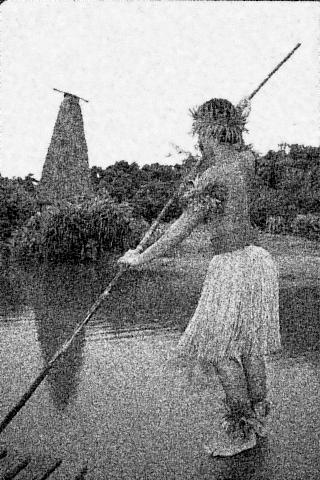
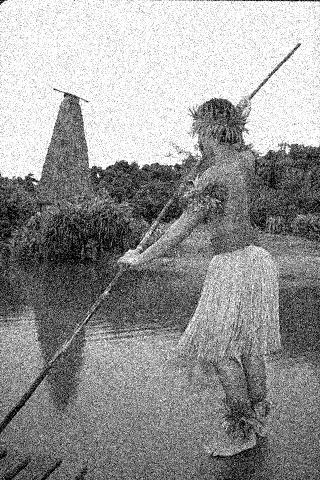
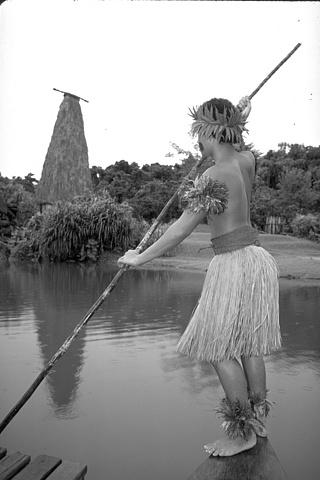


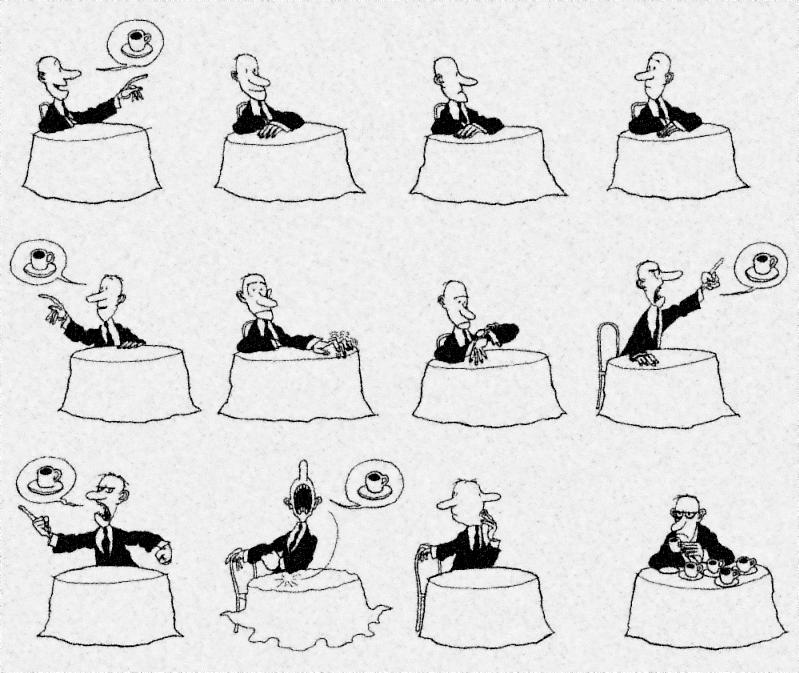
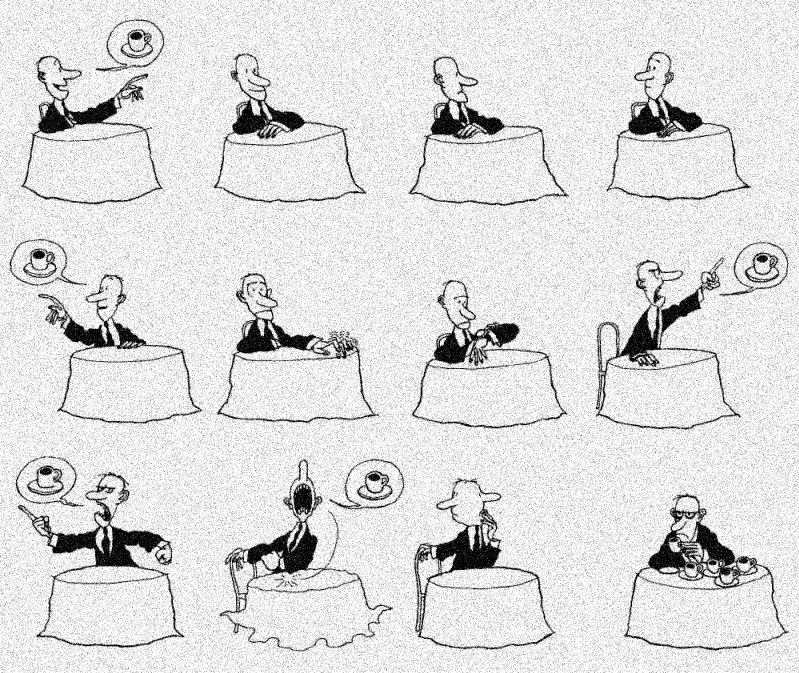
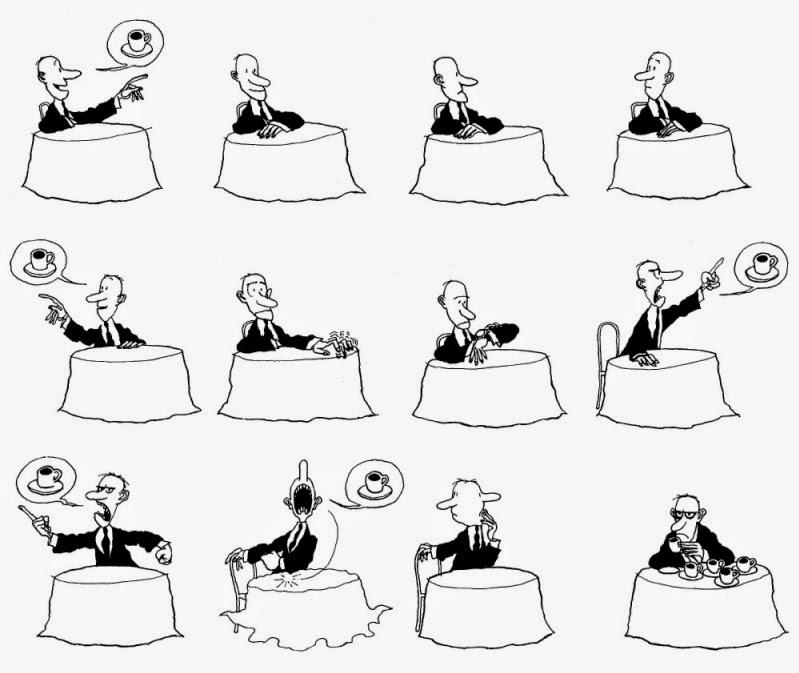

In [83]:
## SOLUTION
###########

from denoising_dataloaders import train_validation_denoising_dataloaders
import vistools
from models import DnCNN, DnCNN_pretrained_grayscale
from training import trainmodel

# data
trainloader, validationloader = train_validation_denoising_dataloaders(
                                            './datasets/quino/', 
                                            noise_sigma=30, 
                                            crop_size=50, 
                                            train_batch_size=256 )


# network model
Denoiser =  DnCNN(1,1,2)

# loss
loss = nn.MSELoss()
loss = nn.L1Loss()


# run the training loop
Denoiser, loss, lossv = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                   num_epochs=100, save_every=10, loss_every=20, 
                                   filename='DnCNN_L2_quino_30')


sigma=30
#m = FFDNet_pretrained_grayscale(sigma)

img_clean = io.imread('datasets/BSD68/test002.png', dtype='float32') 
_,_,_,out = test_denoiser_on_one_image(Denoiser, img_clean[:-1,:-1], sigma=sigma, show=True)


img_clean = io.imread('datasets/quino/03.jpg', dtype='float32') 
_,_,_,out = test_denoiser_on_one_image(Denoiser, img_clean[:-1,:-1,1], sigma=sigma, show=True)


-------------------------

# U-Net [TODO INCOMPLETE]

    O. Ronneberger, P. Fischer, T. Brox, "U-Net: Convolutional Networks for Biomedical Image Segmentation," Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234--241, 2015

<img width=500 src="https://raw.githubusercontent.com/gfacciol/MVA2018-denoising/master/models/unet.png"/>






#### train

In [ ]:
from models import UNet


# network model
Denoiser =  UNet(1,1)

# loss
loss = nn.MSELoss()
#loss = nn.L1Loss()

# data
trainloader, validationloader = train_validation_denoising_dataloaders(
                                          './datasets/Train400/', 
                                           noise_sigma=30, crop_size=64, 
                                           train_batch_size=128 )

# run the training loop
Denoiser, loss, lossv = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                   num_epochs=100, save_every=10, loss_every=20, 
                                   filename='Unet_L2_')


In [ ]:
from skimage import io
import torch
from models import DCT


Denoiser = torch.load('Unet_L2_10.pt')[0]
import vistools




img_clean = io.imread('datasets/BSD68/test002.png', dtype='float32') 
test_denoiser_on_one_image(Denoiser, img_clean, sigma=30)

# FFDNet [TODO INCOMPLETE]

<img width=700 src="https://raw.githubusercontent.com/gfacciol/MVA2018-denoising/master/models/ffdnet.png"/>


Model constructor


     FFDNet(self, sigma=30/255, inchannels=1, outchannels=1, num_of_layers=15, 
                 features=64, kernel_size=3):
        '''
        model for a FFDNet network build using CONV_BN_RELU units 
        this network can handle any level of noise when sigma_map is provided

        sigma: is the default level of noise for the network when sigma_map is not specified
        The rest of parameters  indicate the input and output channels, 
        the kernel size (default 3), the number of layers (15 for grayscale),  
        and number of features (default 64)
        '''


Load pretrained weights


    def FFDNet_pretrained_grayscale(sigma=30, savefile=None, verbose=False):
        '''
        Loads the pretrained weights of DnCNN for grayscale images from 
        https://github.com/cszn/FFDNet.git

        sigma: is the default noise level for the network when sigma_map is not specified
        savefile: is the .pt file to save the model weights 
        returns the FFDNet(1,1) model with 15 layers with the pretrained weights
        '''

In [ ]:
from models import FFDNet, FFDNet_pretrained_grayscale, DnCNN_pretrained_grayscale
from skimage import io


sigma=30
m = FFDNet_pretrained_grayscale(sigma)

img_clean = io.imread('datasets/BSD68/test004.png', dtype='float32') 
_,_,_,out = test_denoiser_on_one_image(m, img_clean[:-1,:-1], sigma=sigma, show=True)


---------------------------
[//]: # (© 2018 Gabriele Facciolo)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018 Gabriele Facciolo. All rights reserved.</div> )